In [1]:
# for data manipulation
import pandas as pd
import numpy as np

# for plotting/visualising the distibution of data
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly import tools

import random
import re

# for pre-processing of the data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
from sklearn.linear_model import LinearRegression
import patsy

## Importing the IRS, Access and Restaurants(from food atlas), life expectancy and mortality rate datasets for analysis

In [2]:
health_irs = pd.read_csv("health_irs.csv")
access = pd.read_csv("access.csv")
life = pd.read_csv('life_exp.csv')
mort = pd.read_csv('mort_rate.csv')
rest = pd.read_csv('restaran.csv')

## Extracting out the required features for analysis from raw data

In [3]:
# features from HEALTH_IRS dataset 
df1 = pd.DataFrame()
df1['FIPS'] = health_irs['FIPS']
df1['Income'] = health_irs['A02650']
df1['health_pay'] = health_irs['A09750']
df1['diab'] = ((health_irs['PCT_DIABETES_ADULTS13'] + health_irs['PCT_DIABETES_ADULTS08']) / 2)
df1['obes'] = ((health_irs['PCT_OBESE_ADULTS13'] + health_irs['PCT_OBESE_ADULTS08']) / 2)

# features from Access dataset
df2 = pd.DataFrame()
df2['FIPS'] = access['FIPS']
df2['la'] = ((access['PCT_LACCESS_POP10'] + access['PCT_LACCESS_POP15']) / 2)
df2['pchla'] = access['PCH_LACCESS_POP_10_15']
df2['hncla'] = ((access['PCT_LACCESS_HHNV10'] + access['PCT_LACCESS_HHNV15']) / 2)

# features from restaurant dataset
df3 = pd.DataFrame()
df3['FIPS'] = rest['FIPS']
df3['exp_ff'] = (rest['PC_FFRSALES07'] + rest['PC_FFRSALES12']) / 2
df3['exp_rest'] = (rest['PC_FSRSALES07'] + rest['PC_FSRSALES12']) / 2
df3['state'] = rest['State']

# merging the diffferent dataframes
dft = df2.merge(df1, on = 'FIPS')
df = pd.merge(dft, df3, on='FIPS')
df.shape
df.drop('FIPS', axis=1, inplace=True)
dfg = df.groupby(['state'], sort=False).mean()

In [4]:
mort.head()

,gnd,pctile,age_at_d,yod,lag,mortrate,hh_inc,deaths,count
0,F,1,40,2001,2,0.004409,364.823006,95,21545
1,F,1,40,2002,2,0.005786,383.668744,124,21431
2,F,1,40,2003,2,0.005046,374.732925,107,21203
3,F,1,40,2004,2,0.004787,370.528819,100,20890
4,F,1,40,2005,2,0.004725,356.143865,93,19684


In [5]:
print(df1.shape)
print(df2.shape)
print(df3.shape)

(3018, 5)
(3143, 4)
(3143, 4)


In [6]:
df.head()

,la,pchla,hncla,Income,health_pay,diab,obes,exp_ff,exp_rest,state
0,32.915956,-5.056026,3.318059,183214.0000,52.000000,12.20,32.80,662.157044,498.331247,AL
1,18.042981,-13.204891,2.026471,267456.4783,80.652174,10.10,26.80,662.157044,498.331247,AL
2,21.473266,6.067799,4.232624,54174.1250,15.500000,16.00,41.00,662.157044,498.331247,AL
3,4.395039,-7.224696,3.140004,107697.7273,34.909091,12.95,36.30,662.157044,498.331247,AL
4,4.599110,140.568857,3.302897,204151.8750,71.687500,12.75,33.25,662.157044,498.331247,AL


In [7]:
df3['state'].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [8]:
df.shape

(3018, 10)

In [9]:
life.head()

,gnd,pctile,year,count,hh_inc,le_agg,le_raceadj,sd_le_agg,sd_le_raceadj
0,F,1,2001,398740,499.10938,79.682068,79.893463,0.392838,0.385240
1,F,1,2002,411159,541.30695,79.183594,79.410622,0.353981,0.346817
2,F,1,2003,420298,529.13910,79.364410,79.572174,0.364780,0.359097
3,F,1,2004,427728,499.29950,79.898407,80.092476,0.352018,0.347992
4,F,1,2005,433665,474.14536,80.283600,80.465935,0.334612,0.330986


In [10]:
print(life.shape)
print(mort.shape)

(2800, 9)
(85400, 9)


In [11]:
life.describe()

,pctile,year,count,hh_inc,le_agg,le_raceadj,sd_le_agg,sd_le_raceadj
count,2800.000000,2800.000000,2800.000000,2.800000e+03,2800.000000,2800.000000,2800.000000,2800.000000
mean,50.500000,2007.500000,433773.845714,9.764774e+04,83.627406,83.672665,0.560205,0.550729
std,28.871226,4.031849,18872.974468,1.977964e+05,3.657129,3.600353,0.107541,0.106312
min,1.000000,2001.000000,387717.000000,1.375935e+02,67.862122,68.343384,0.179007,0.185262
25%,25.750000,2004.000000,421633.000000,3.083662e+04,81.774229,81.858478,0.494333,0.485487
50%,50.500000,2007.500000,436506.000000,6.119835e+04,84.143944,84.189407,0.560017,0.550386
75%,75.250000,2011.000000,445446.500000,1.048515e+05,86.313641,86.306168,0.624831,0.614215
max,100.000000,2014.000000,462127.000000,2.435930e+06,91.120705,91.076477,0.998827,0.974649


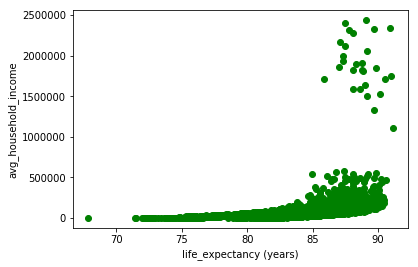

In [12]:
plt.scatter(life['le_agg'], life['hh_inc'], c='g')
plt.xlabel('life_expectancy (years)')
plt.ylabel('avg_household_income')
plt.show()

In [13]:
from scipy.stats import linregress
print(linregress(life['le_agg'], life['hh_inc']))

LinregressResult(slope=19025.20527166232, intercept=-1493380.8259447026, rvalue=0.35176392910878, pvalue=2.3777503659974395e-82, stderr=957.1306330401748)


In [14]:
mort.head()

,gnd,pctile,age_at_d,yod,lag,mortrate,hh_inc,deaths,count
0,F,1,40,2001,2,0.004409,364.823006,95,21545
1,F,1,40,2002,2,0.005786,383.668744,124,21431
2,F,1,40,2003,2,0.005046,374.732925,107,21203
3,F,1,40,2004,2,0.004787,370.528819,100,20890
4,F,1,40,2005,2,0.004725,356.143865,93,19684


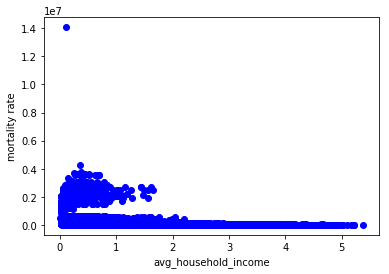

In [26]:
mort['pct_mort'] = mort['mortrate']*100
plt.scatter(mort['pct_mort'], mort['hh_inc'], c='b')
plt.ylabel('mortality rate')
plt.xlabel('avg_household_income')
plt.show()

In [16]:
from scipy.stats import linregress
print(linregress(mort['pct_mort'], mort['hh_inc']))

LinregressResult(slope=-49754.456372051616, intercept=128217.66788277449, rvalue=-0.14719222157380624, pvalue=0.0, stderr=1144.1078058164944)


In [17]:
c = mort['pct_mort'].corr(mort['hh_inc'])
print(c)

-0.14719222157380624
